In [2]:
# --- Core libraries ---
import os 
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import geopandas as gpd
from shapely.geometry import Point
from tabulate import tabulate
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point 
import category_encoders as ce
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
import joblib # for saving models and data


# --- Scikit-learn: model training, preprocessing, CV, evaluation ---
from sklearn.model_selection import (
    GroupKFold,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
    GridSearchCV
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    balanced_accuracy_score,
    roc_auc_score,
    make_scorer,
    ConfusionMatrixDisplay
)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import BallTree
from sklearn.feature_selection import RFE 
from sklearn.feature_selection import RFECV

# --- XGBoost ---
from xgboost import XGBRegressor, plot_tree, plot_importance
import xgboost as xgb # Optional: useful for checking version

# --- Other ---
from haversine import haversine # for distance calculations
import scipy.stats as stats # for statistical tests
import gstools as gs #variogram modeling
from sklearn.metrics import pairwise_distances # for distance calculations
from scipy.cluster.hierarchy import linkage, dendrogram #for hierarchical clustering dendrogram
from sklearn.cluster import AgglomerativeClustering #for hierarchical clustering
from sklearn.cluster import DBSCAN #for DBSCAN clustering
from scipy.spatial.distance import squareform #for distance matrix dendrogram



#--- Custom Functions as defined by the user ---
import sys
sys.path.append(os.path.abspath("../tools"))
import functions



#load in data to analyse and model

In [4]:
#Load in feature selected testdata and future holdout
testdata = pd.read_csv("testdata.csv")
future_holdout = pd.read_csv("holdoutdata.csv")

#Load in final model: 
best_model = joblib.load("final_model/xgb_spatial_model.pkl")

#### Split data into future holdout x_y and testdata X_Y

In [5]:
X_encoded_selected = testdata.drop("Grain.yield..tons.ha.1.", axis=1)  
y = testdata["Grain.yield..tons.ha.1."]

X_holdout = future_holdout.drop("Grain.yield..tons.ha.1.", axis=1)  
y_holdout = future_holdout["Grain.yield..tons.ha.1."]

#### Observing feature importance for whole data according to model

In [35]:
explainer = shap.TreeExplainer(best_model, X_encoded_selected)
shap_values = explainer(X_encoded_selected)

100%|===================| 21667/21699 [05:10<00:00]        

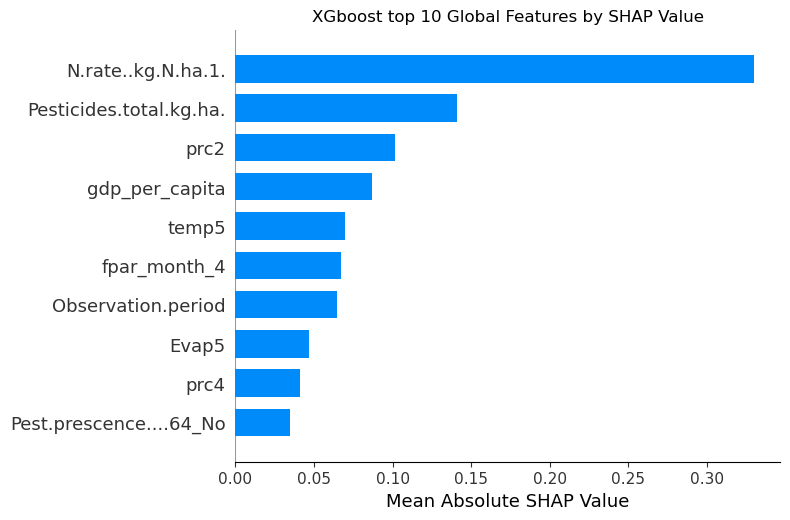

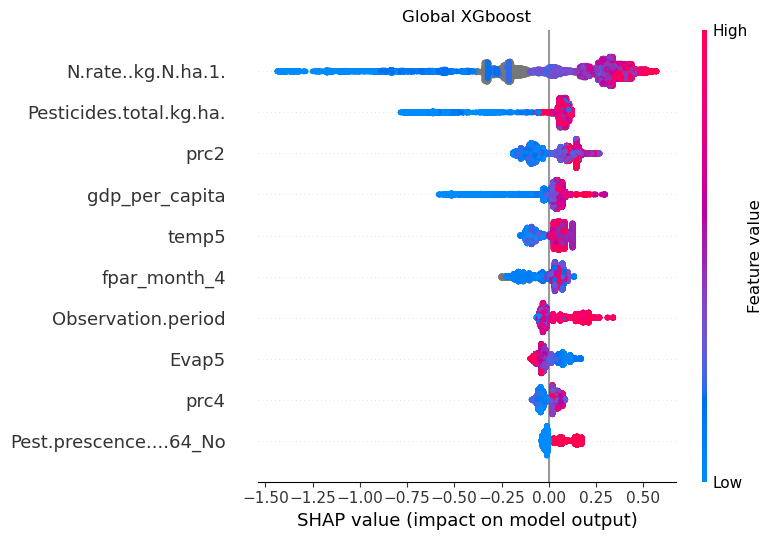

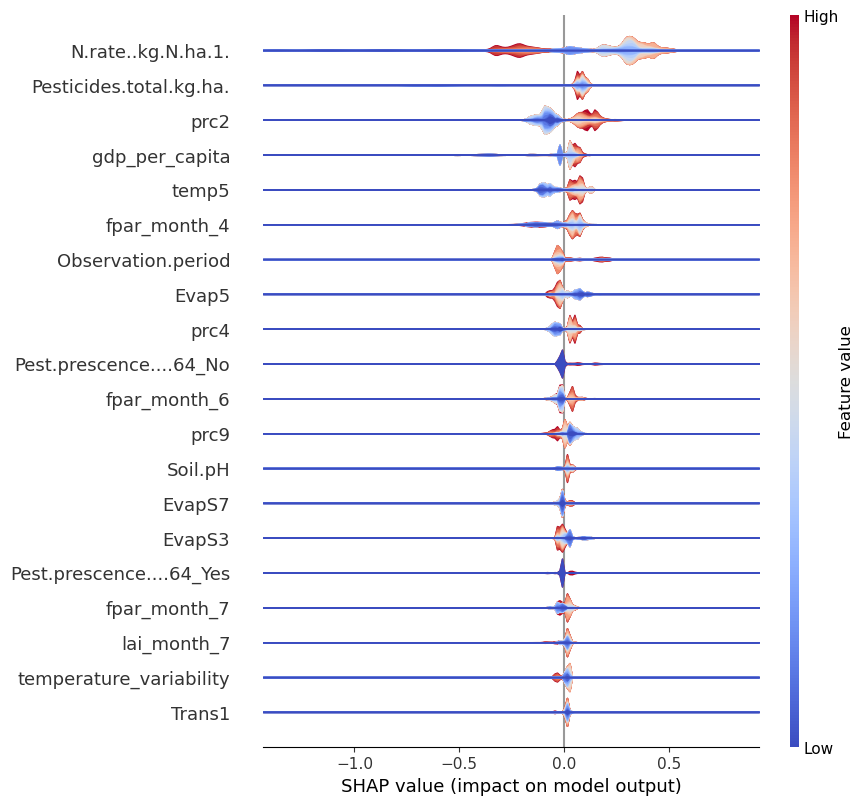

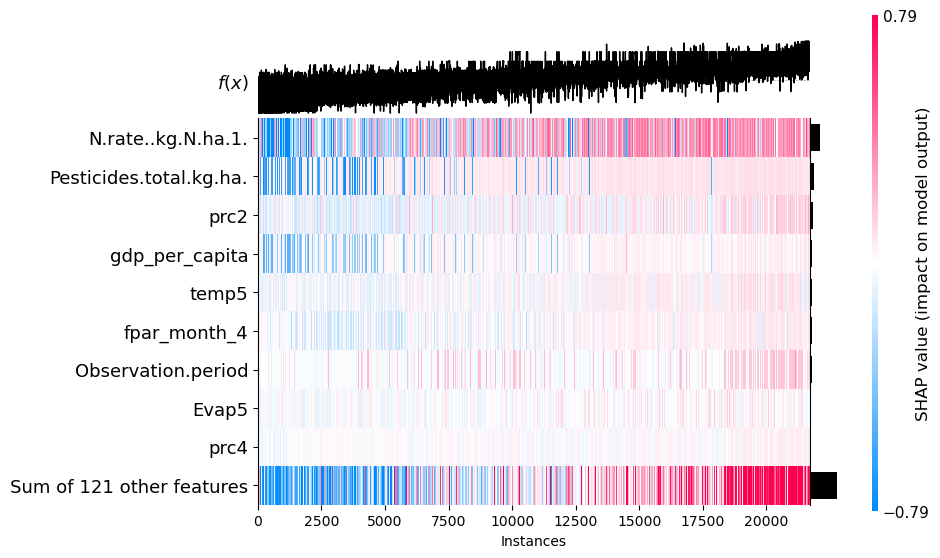

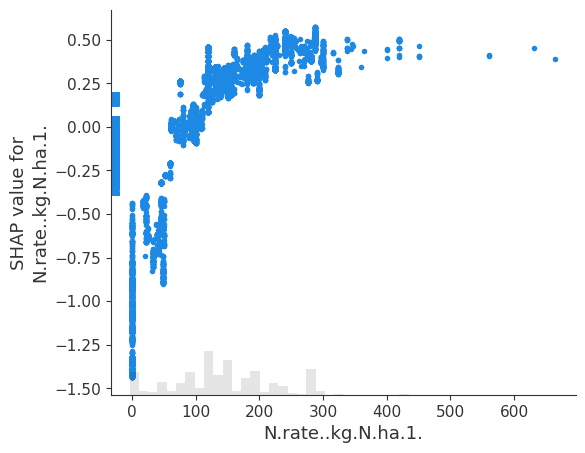

In [43]:

# Feature importance from SHAP values
feature_importance = np.abs(shap_values.values).mean(axis=0)
top_features = np.argsort(feature_importance)[::-1][:10]
top_feature_names = np.array(shap_values.feature_names)[top_features]

# SHAP Summary: Bar Plot
shap.summary_plot(shap_values, max_display=10, plot_type="bar", show=False)
plt.title("XGboost top 10 Global Features by SHAP Value")
plt.xlabel("Mean Absolute SHAP Value")
plt.tight_layout()  # Add extra padding
plt.subplots_adjust(bottom=0.15)  # Give more space at bottom
plt.show()

#SHAP Summary: Beeswarm Plot
shap.summary_plot(shap_values, X_encoded_selected, show=False, max_display=10)
plt.title("Global XGboost")
plt.tight_layout()
plt.show()

# SHAP Summary: violin plot
shap.plots.violin(shap_values, plot_type="layered_violin")  # explains one prediction

#SHAP Summary: Ordered heatmap according to increasing yield
order = np.argsort(y)
shap.plots.heatmap(shap_values, instance_order=order)

#Shap Summary dependence plot for the top feature
shap.plots.scatter(shap_values[:, top_features[0]])

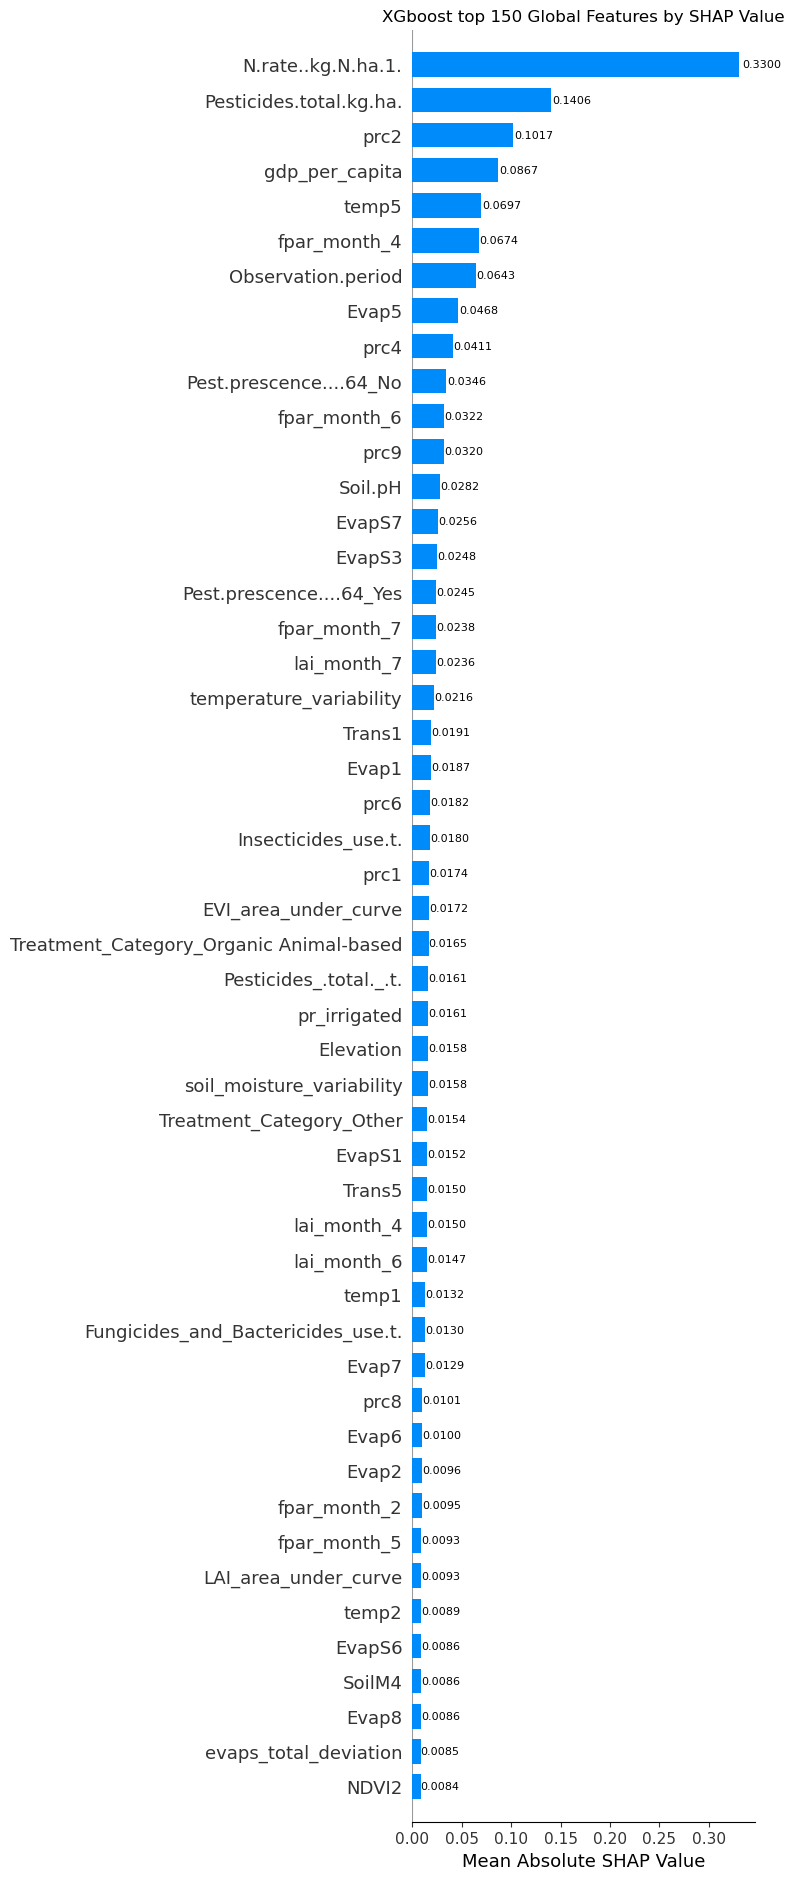

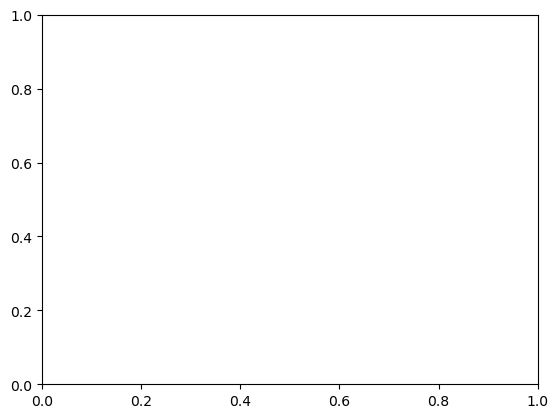

In [47]:
# Method 1: Using matplotlib to add text annotations (CORRECTED)
plt.figure(figsize=(10, 12))

# Create the SHAP bar plot
shap.summary_plot(shap_values, max_display=50, plot_type="bar", show=False)

# Get the current axes and add value labels
ax = plt.gca()  # Get current axes after SHAP plot is created
bars = ax.patches  # Get all the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    # Add text annotation next to each bar
    ax.text(width + width*0.01,  # x position (slightly to the right of bar end)
            bar.get_y() + bar.get_height()/2,  # y position (center of bar)
            f'{width:.4f}',  # text to display (SHAP value rounded to 4 decimals)
            ha='left',  # horizontal alignment
            va='center',  # vertical alignment
            fontsize=8)

plt.title("XGboost top 150 Global Features by SHAP Value")
plt.xlabel("Mean Absolute SHAP Value")
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# Method 1b: Even simpler - just add this after your existing code
# Your original code:
# shap.summary_plot(shap_values, max_display=150, plot_type="bar", show=False)
# plt.title("XGboost top 150 Global Features by SHAP Value")
# plt.xlabel("Mean Absolute SHAP Value")

# Then add these lines:
ax = plt.gca()
bars = ax.patches
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
            f'{width:.4f}', ha='left', va='center', fontsize=8)


In [ ]:
categories = {
    'Remote Sensing': ['NDVI', 'EVI', 'LAI', 'FPAR variables'],
    'Climate': ['Temperature', 'Precipitation', 'Evaporation', 'Evaporative Stress', 'Soil Moisture', 'Transpiration'],
    'Soil': ['Texture (Clay/Sand/Silt)', 'Chemistry (pH/SOC/N)', 'Topography (Elevation/AEZ)'],
    'Management': ['Crop variety', 'Treatments', 'Irrigation', 'Nitrogen', 'Pest control', 'Pesticides'],
    'Socioeconomic': ['GDP per capita', 'Year', 'Sowing year']
}

### Model outcome for holdoutdata

In [9]:


print(f"Holdout prepared: {X_holdout.shape}")

# Predict on holdout test set
y_pred = best_model.predict(X_holdout)

# Evaluation Metrics
mae = mean_absolute_error(y_holdout, y_pred)
rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))
r2 = r2_score(y_holdout, y_pred)



Holdout prepared: (1010, 130)


Holdout Test Set Evaluation Metrics:
  MAE : 1.4330
  RMSE: 1.7752
  R²  : 0.3254


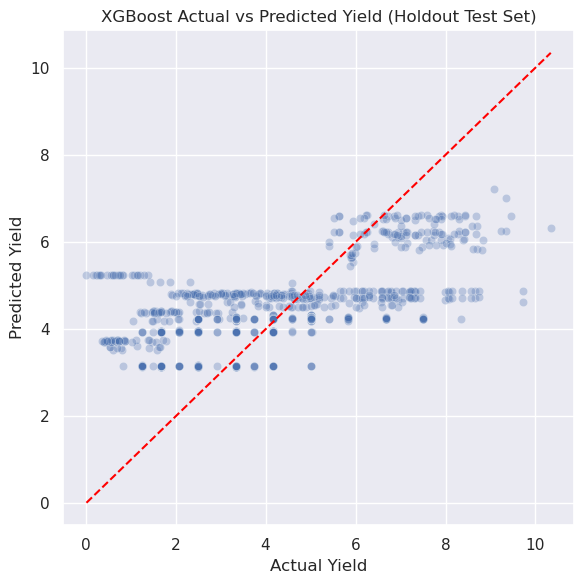

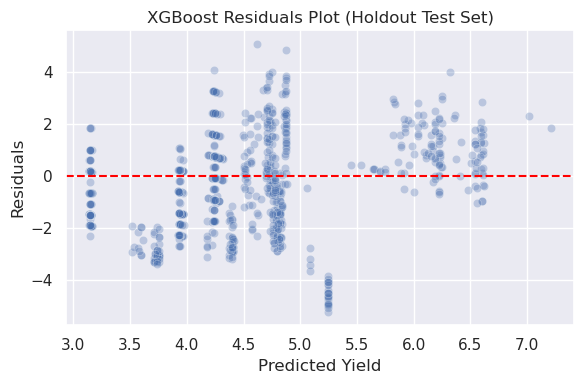

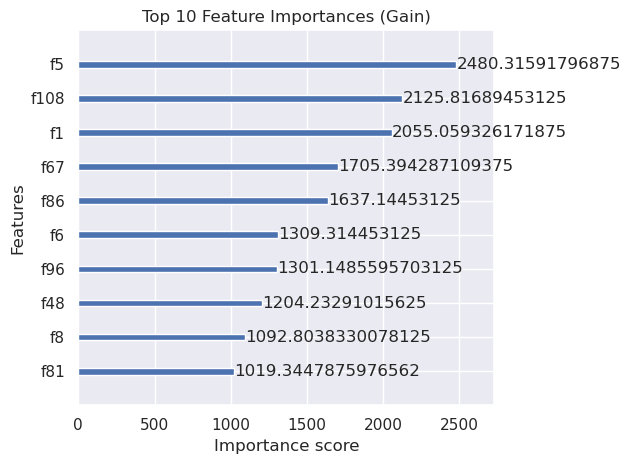

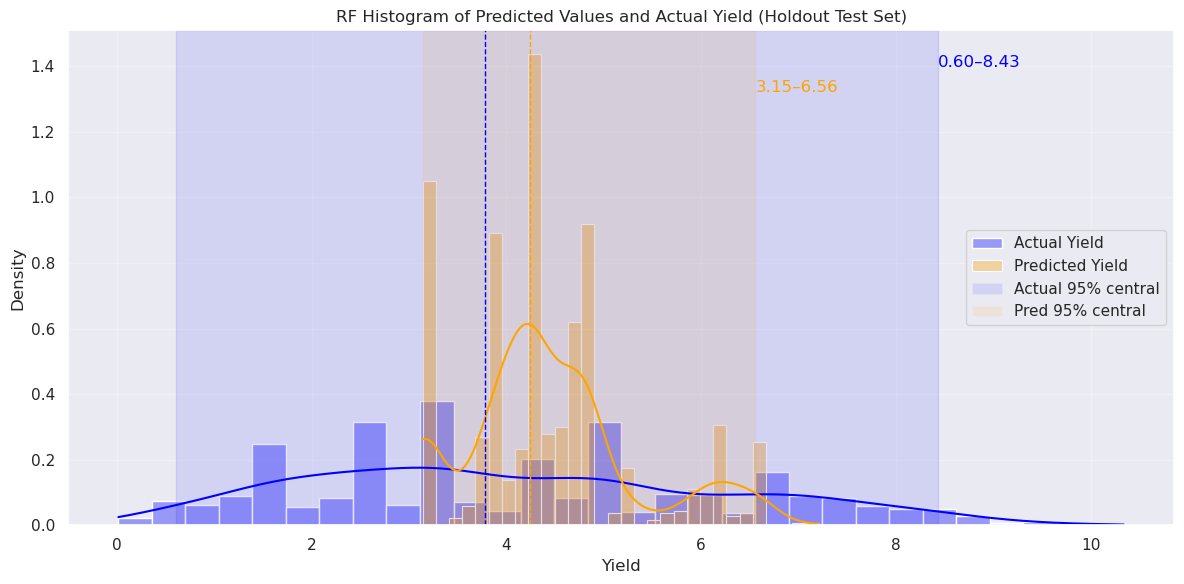

In [ ]:
print("Holdout Test Set Evaluation Metrics:")
print(f"  MAE : {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²  : {r2:.4f}")

# Actual vs Predicted Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_holdout, y=y_pred, alpha=0.3)
plt.plot([y_holdout.min(), y_holdout.max()], [y_holdout.min(), y_holdout.max()], '--', color='red')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("XGBoost Actual vs Predicted Yield (Holdout Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals Plot
residuals = y_holdout - y_pred
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Yield")
plt.ylabel("Residuals")
plt.title("XGBoost Residuals Plot (Holdout Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance (XGBoost native)
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importances (Gain)")
plt.tight_layout()
plt.show()


In [ ]:
plt.style.use('default')  # before any plotting

# SHAP Explanation (on holdout data)
explainerholdout = shap.TreeExplainer(best_model)
holdout_shap_values = explainerholdout(X_holdout)

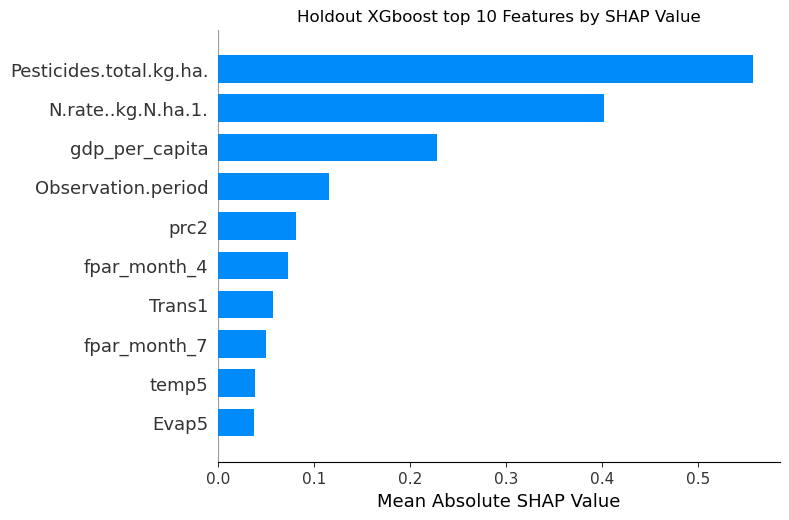

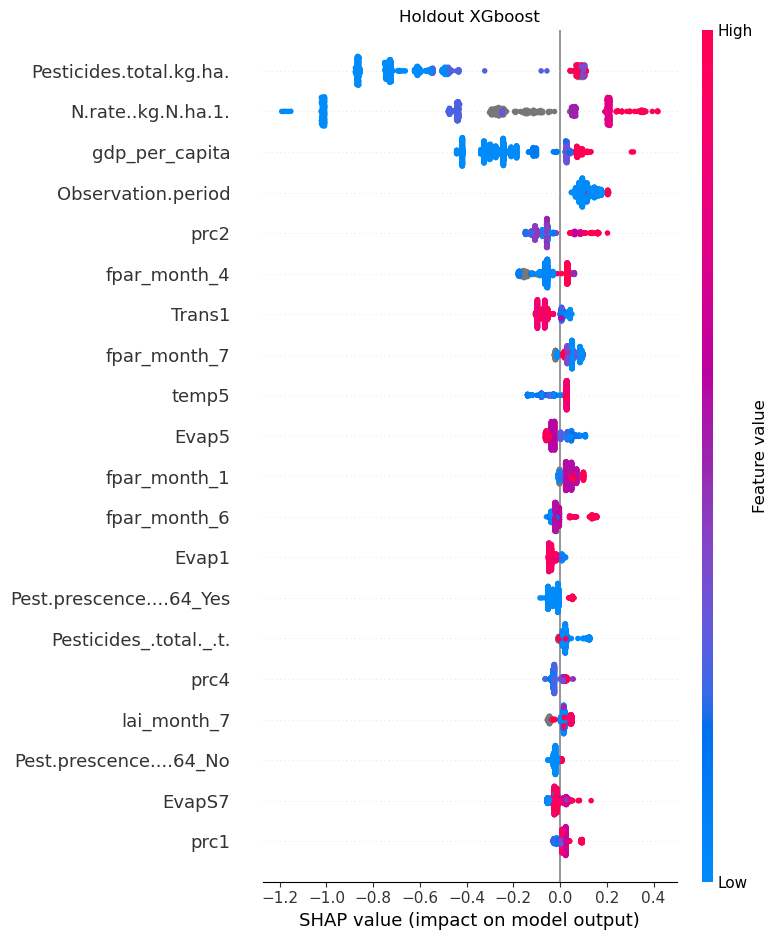

/home/sebastian-dohne/anaconda3/envs/wheatproject/lib/python3.13/site-packages/shap/plots/_violin.py:304: UserWarning: Not enough data in bin #11 for feature N.rate..kg.N.ha.1., so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(
/home/sebastian-dohne/anaconda3/envs/wheatproject/lib/python3.13/site-packages/shap/plots/_violin.py:304: UserWarning: Not enough data in bin #12 for feature N.rate..kg.N.ha.1., so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(
/home/sebastian-dohne/anaconda3/envs/wheatproject/lib/python3.13/site-packages/shap/plots/_violin.py:304: UserWarning: Not enough data in bin #14 for feature N.rate..kg.N.ha.1., so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(
/home/sebastian-dohne/anaconda3/envs/wheatproject/lib/python3.13/site-packages/shap/plots/_violin.py:304: UserWarning: Not enough data in bin #16 for feature N.rate..kg.N.ha.1., so it'll be ignored. Try increasing 

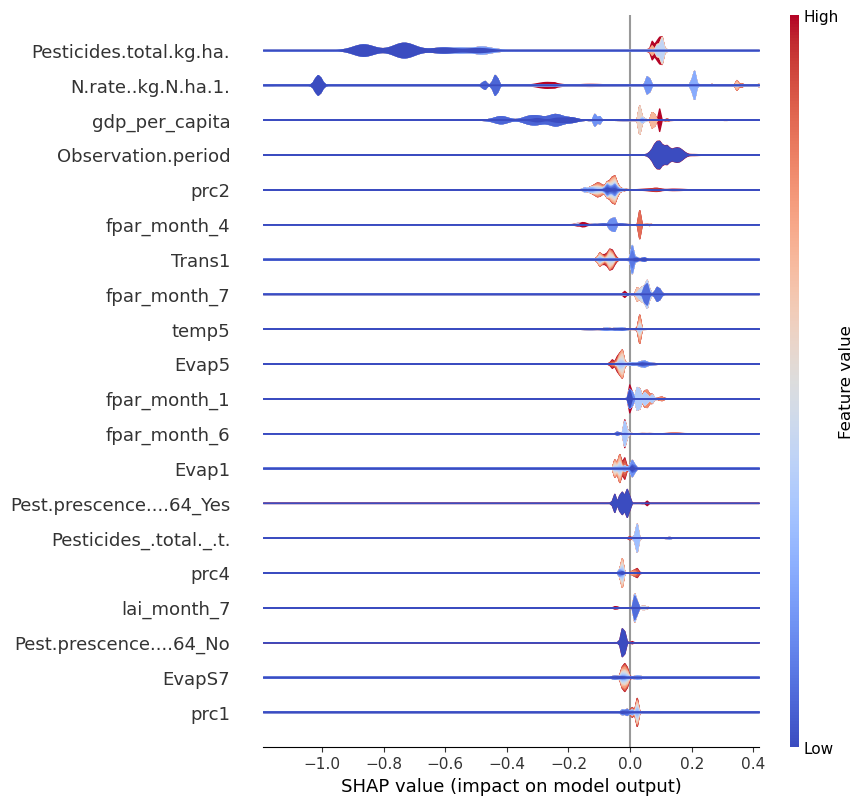

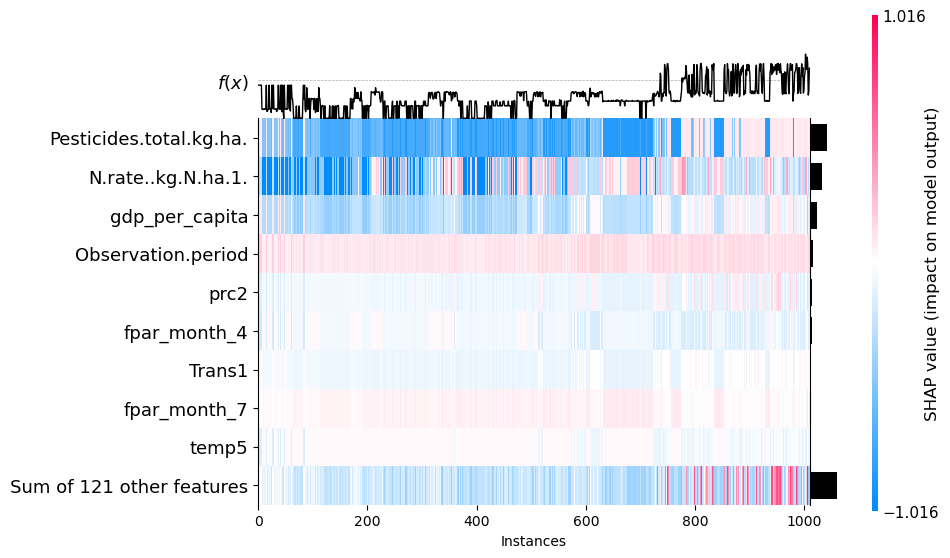

<Axes: xlabel='Instances'>

In [40]:

# SHAP Summary: Bar Plot
shap.summary_plot(holdout_shap_values, max_display=10, plot_type="bar", show=False)
plt.title("Holdout XGboost top 10 Features by SHAP Value")
plt.xlabel("Mean Absolute SHAP Value")
plt.tight_layout()  # Add extra padding
plt.subplots_adjust(bottom=0.15)  # Give more space at bottom
plt.show()

# SHAP Summary: Beeswarm Plot
shap.summary_plot(holdout_shap_values, X_holdout, show=False)
plt.title("Holdout XGboost")
plt.tight_layout()
plt.show()

# SHAP Summary: violin plot
shap.plots.violin(holdout_shap_values, plot_type="layered_violin")  # explains one prediction

#SHAP Summary: Ordered heatmap according to increasing yield
order = np.argsort(y_holdout)
shap.plots.heatmap(holdout_shap_values, instance_order=order)

In [6]:
explainer = shap.TreeExplainer(best_model)
shap_interaction = explainer.shap_interaction_values(X_holdout)

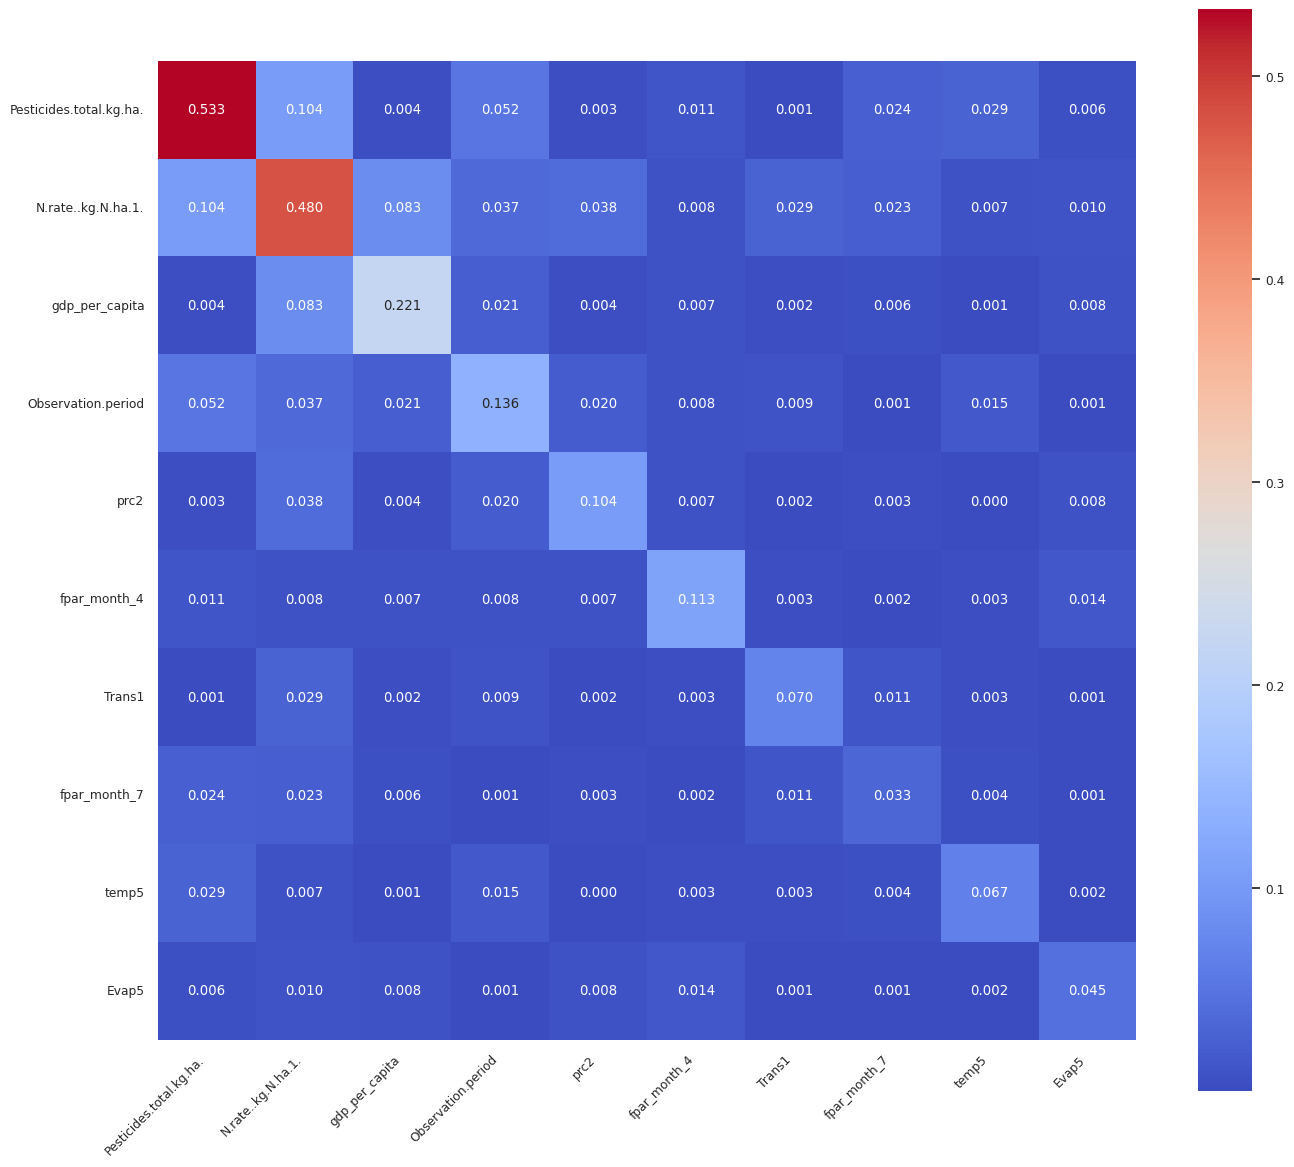

In [ ]:
# --- Top-10 by main-effect SHAP ---
sv = explainer.shap_values(X_holdout)
if isinstance(sv, list):  # multiclass: average across classes
    feature_importance = np.mean([np.mean(np.abs(s), axis=0) for s in sv], axis=0)
else:                      # regression / single-output
    feature_importance = np.mean(np.abs(sv), axis=0)

top_10_idx = np.argsort(feature_importance)[-10:][::-1]
top_10_names = X_holdout.columns[top_10_idx]

# --- Interactions (computed once, then subset to top-10) ---
shap_interaction = explainer.shap_interaction_values(X_holdout)  # (n, F, F)

# keep only the top-10 rows/cols
shap_interaction_top10 = shap_interaction[:, top_10_idx][:, :, top_10_idx]

# --- Aggregate and format ---
mean_shap = np.abs(shap_interaction_top10).mean(0)   # (10, 10)
mean_shap = np.round(mean_shap, 4)
df = pd.DataFrame(mean_shap, index=top_10_names, columns=top_10_names)

# double off-diagonals (use positional mask, not value comparison)
mask = ~np.eye(df.shape[0], dtype=bool)
vals = df.values
vals[mask] = vals[mask] * 2  # in-place

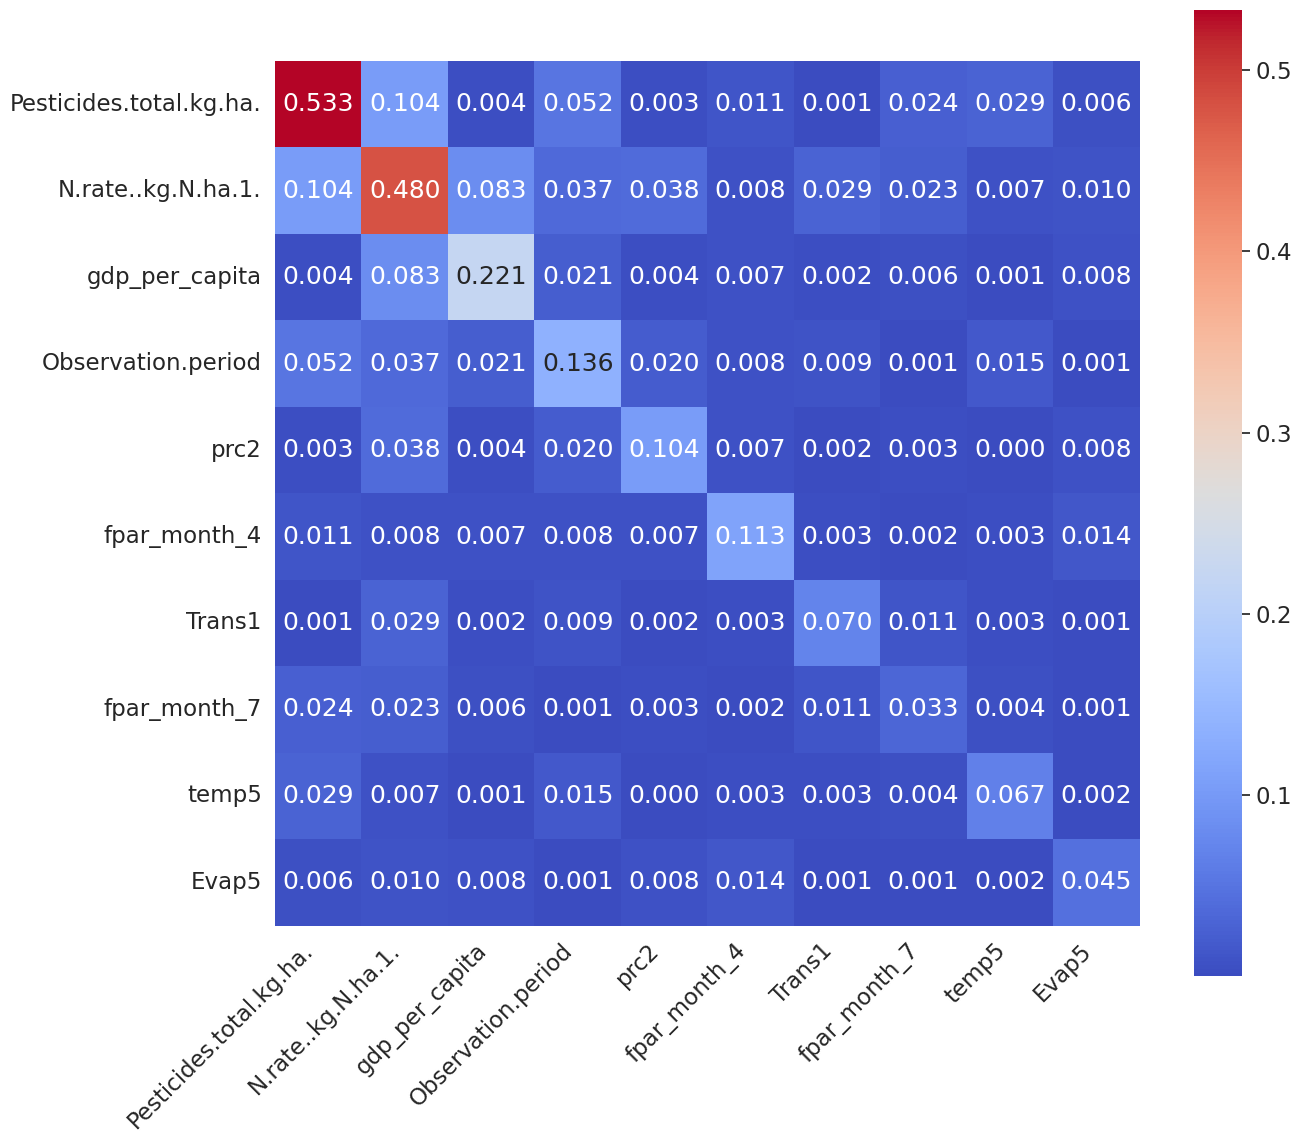

In [8]:

# --- Plot ---
plt.figure(figsize=(14, 12))
sns.set(font_scale=1.5)
sns.heatmap(df, cmap="coolwarm", annot=True, fmt=".3f", square=True)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()